# EE 123 Lab1 - Time Domain Sonar Lab

### Written by Miki Lustig and Frank Ong 2016
#### Edited, debugged and ported to Rapberry Pi  Nick Antipa, Li-Hao Yeh and Miki Lustig 2018

In this lab, we will interact with physical time-domain signals. The first part will involve generating and recording sounds on the Raspberry-Pi. We will use the chirp signal to characterize the response of the speaker-microphone system and look at detecting signals using cross-correlation.
In the second part, we will build on part one and use the speaker-microphone system to develop a simple sonar.


#### When using the raspberry pi -- 

The RaspberryPi does not have a microphone input. In order to use both audio input and output, we use a sound extension board (FE-PI AUDIO Z V2). This sound extension is in fact an Analog-to-Digital and Digital-to-Analog device. 

* connect the microphone to the mic port on the Y adaptor
* connect the Y adaptor to the HEADPHONE/MIC port on the sound extension
* connect the speaker to the speaker LINE OUT port on the sound extension
* make sure the speaker is powered -- e.g. connected to a USB either on your computer, or the pi

<center><img src="./sonar_lab_equipment.JPG" alt="gsm" style="width: 400px;"/></center>
<center>Figure 1: Equipment connection for this lab. </center>


In [1]:
##### Import functions and libraries
import numpy as np, matplotlib.pyplot as plt
from matplotlib.pyplot import *
from scipy import signal
from numpy import *
import sounddevice as sd


%matplotlib inline

## Part 1: Chirping!

For this assignment you will use the the raspberry-pi equipped with a sound extension, a USB powered speaker and a microphone. When playing a sound and recording, the signal goes through several systems. In particular it goes through the response of the sound extension output, the speaker, the room we are in and the response of the microphone and receive part of the sound extension.

A chirp is a a signal in which the frequency increases linearly with time. In this assignment we will generate a chirp signal and use it to measure the amplitude of the frequency response of our speaker-room-microphone system. This lab will work best in a quiet environment -- We recommend that you execute the lab at home or in a quiet place before submitting it. 

A instantaneous frequency is defined as the derivative of the phase of a signal, $f = \frac{1}{2\pi} \frac{d\phi (t)}{ dt} $. For example, the instantaneous frequency of $\cos(\phi(t))=\cos(2\pi f_0 t)$ is  

$$f = \frac{d\phi (t)}{2\pi dt}  = f_0$$ 


For a linear chirp, the frequency changes linearly over time. The instantaneous frequency is therefore defined as 

<center>$$ f(t) = f_0 + kt. $$</center>


So,  

<center>$$ x(t) = \sin(2\pi\int_0^t f(t')dt') = \sin(2\pi\int_o^t(f_0+kt')dt') = \sin(2\pi(f_0+\frac{k}{2}t)t) $$</center>


### Part I Task I: Generating the Chirp

Generate a 10 seconds long chirp signal, sampled at 48,000[Hz] with a frequency range of 20[Hz] to 20,000[Hz]. Set the magnitude of the chirp to 0.5. This will help prevent non-linearities when we play the sound later. 

* Given $T$=total time length, $f_0$=start frequency, $f_1$ = end frequency, derive a formula $f(t)$ for the frequency sweep.
* Find the formula for the phase by integrating $\phi(t) = \int_0^T f(t)dt$ to get the phase function.

Now, 
* Set the sample-rate frequency `fs = 48000` Hz
* Generate a time index from `t=0` to `t=10` with sampling rate of 48000 Hz
* Generate a vector of frequency vs time: `phi_of_t`  (  $\phi(t)$ )
* Generate the chirp function `s_chirp` with amplitude of 0.5 by plugging the phase into a sinusoid. 
  
  


In [2]:
fs = 48000
f0 = 20
f1 = 20000
T = 10

# generate time index
timeIndex = np.arange(0, 10.0, 1/fs)
# generate chirp signal
k_f = (f1 - f0)/T
phi_of_t = 2*np.pi*np.multiply(timeIndex, ((k_f/2)*timeIndex + f0))
s_chirp = np.sin(phi_of_t) * 0.5


* Plot the first $\frac{1}{2}$ second of the chirp (`s_chirp`), you will notice that the carrier frequency increases and that the chirp has a constant envelope. To get a nice figure, make sure the aspect ratio of the figure is height/width = 0.2 . Label the axis and figure appropriately. 

(480000,)


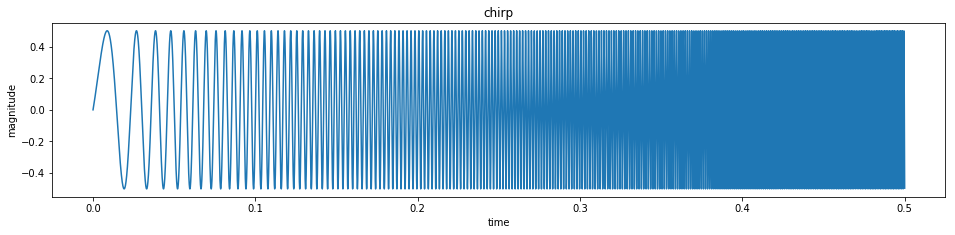

In [3]:
# Set the aspect ratio such that the image is wide
print(s_chirp.shape)

width, height = figaspect(0.2)
fig = figure(figsize=(width,height))

#Your code below:
plt.plot(timeIndex[:int(fs*0.5)], s_chirp[:int(fs*0.5)])

plt.xlabel("time")
plt.ylabel("magnitude")
plt.title("chirp")

* Plot the magnitude frequency response of the sequence from 0 to $\pi$ using the function `signal.freqz`. Note, that the digital frequency range represents a physical frequency range of 0[hz] to 24000[Hz]. To get a nice figure, make sure the aspect ratio of the figure is height/width = 0.2. Label the axis and figure appropriately. 

The `signal.freqz` function on the Pi is very slow-- be patient. 

In [7]:
# # generate frequency response of chirp
w, h = signal.freqz(s_chirp);

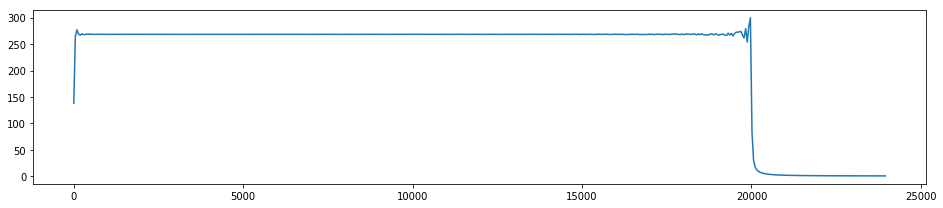

In [8]:
# generate frequency index
width, height = plt.figaspect(0.2)
fig = plt.figure(figsize=(width,height))
plot(24000*w/np.pi, abs(h))

Explain why the chirp is an appropriate signal to measure the magnitude frequency response of a system. 


#### Your answer here:
 For any frequency that's lower than 20000(in this case), the amplitude of this unit frequency response is always constant, so we can easily calculate the value of magnitude frequency.

### Part I Task II: Playing and Recording the Chirp
Now, we will play the sound of the chirp on our computer speaker and simultaneously record using the microphone. 

#### Instructions for the Raspberry pi (EE123 2019):

* To setup the output and input volume, in a terminal, run `alsamixer`. Make sure the card showing is: Fe-Pi Audio. (Use F6 to toggle between sound card) 

You can use arrows to move between Headphone, Lineout, Mic, and capture. Use the `M` key to toggle between on (00) and Mute (MM). Use the Keys Q and Z to change the gain of the left speaker, and E and C to change the gain of the right speaker.  F4 will bring you to the page of capture configuration. 

For the sonar to work well we will need to use either the right or left speaker, but not both. Make sure the gain for one of them is 0.

For this lab, you will only need to toggle: 
* "Lineout", "Mic", "Capture Mux" tabs in the playback page
* "Mic" and "Capture" tabs in the capture page

Make sure you get good amount of volume and microphone gain to avoid low volume and saturation for proper recording.

We also prepare a piece of code for configuring to our setting of the sound extension that works for our system. Note that the settings for different devices may change due to different hardware performances. If it does not work on your system, please experiment a better suited one for yourself.

__Sound extension configuration:__

In [4]:
# set up alsamixer volumes for the raspberry pi

!amixer -c 1 -- sset 'Capture Mux' 'MIC_IN'
!amixer -c 1 -- sset Lineout playback unmute
!amixer -c 1 -- sset Lineout playback  50%,0%
!amixer -c 1 -- sset Mic capture  67%
!amixer -c 1 -- sset Mic playback  59%


Simple mixer control 'Capture Mux',0
  Capabilities: enum
  Items: 'MIC_IN' 'LINE_IN'
  Item0: 'MIC_IN'
Simple mixer control 'Lineout',0
  Capabilities: pvolume pswitch pswitch-joined
  Playback channels: Front Left - Front Right
  Limits: Playback 0 - 31
  Mono:
  Front Left: Playback 16 [52%] [-7.50dB] [on]
  Front Right: Playback 0 [0%] [-15.50dB] [on]
Simple mixer control 'Lineout',0
  Capabilities: pvolume pswitch pswitch-joined
  Playback channels: Front Left - Front Right
  Limits: Playback 0 - 31
  Mono:
  Front Left: Playback 16 [52%] [-7.50dB] [on]
  Front Right: Playback 0 [0%] [-15.50dB] [on]
Simple mixer control 'Mic',0
  Capabilities: volume volume-joined
  Playback channels: Mono
  Capture channels: Mono
  Limits: 0 - 3
  Mono: 3 [100%] [40.00dB]
Simple mixer control 'Mic',0
  Capabilities: volume volume-joined
  Playback channels: Mono
  Capture channels: Mono
  Limits: 0 - 3
  Mono: 2 [67%] [30.00dB]


__Playing and recording audio:__

* Run the following code. It is an example of how to play and record sound at the same time using sounddevice package.

The resulting received sequence will be stored in the variable `rcv_chirp`.

In [5]:
# set default sample rate and number of channels. 

sd.default.samplerate=48000
sd.default.channels = 1
rcv_chirp = sd.playrec(s_chirp, fs, channels=1,blocking=False) # Play the chirp

rcv_chirp = rcv_chirp.reshape((rcv_chirp.shape[0],)) # Reshape the vector for proper transform later
# rcv_chirp.shape

* Plot the frequency response of the received sequence. 
* Also, plot the absolute value of the received signal. Plotting the absolute value (sort of) displays the envelope of the chirp. 

Label the figures and use an aspect ratio of Height/Width = 0.2


In [6]:
# generate frequency response of chirp
w_, RCV_chirp = signal.freqz(rcv_chirp)

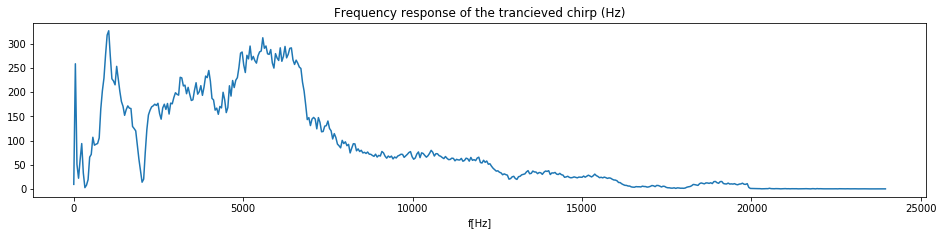

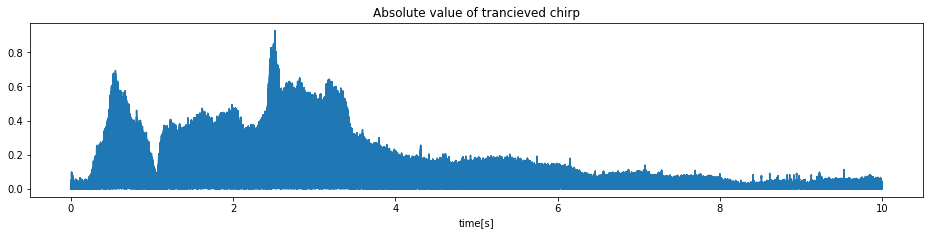

In [7]:
## Plot chirp response

# generate frequency index
f = 24000 * w_ / np.pi
# generate a time index
t = np.arange(0, 10.0, 1/fs)

width, height = figaspect(0.2)
plt.figure(figsize=(width,height))
plt.plot(f, abs( RCV_chirp ) )
plt.title('Frequency response of the trancieved chirp (Hz)')
plt.xlabel('f[Hz]')

plt.figure(figsize=(width,height))
plt.plot(t, abs(rcv_chirp))
plt.title('Absolute value of trancieved chirp');
plt.xlabel('time[s]')

* Comment on the results you got. In addition, what is the implicit assumption we are making in order to claim that the result is a frequency response? 
(HINT: consider the case when the chirp was very short)

#### Answers here:
The absolute value of trancieved chirp form the envenlop of frequency response's amplitude.
We assume the chirp signal is changing steadily and slowly enough as a constant frequency signal.


### Part I, Task III: Envelope detection with Hilbert transform. 
The absolute value of the of the result "sort of" displays the envelope, however it is still modulated by the (now rectified) frequency sweep carrier. If we write down the response, it can be expressed approximately as 

$$y[n] = |H[n]| \sin(2\pi (f_0 +k[n*T])nT + \angle H[n])$$

where $|H[n]|$ is the frequency response for the instantaneous frequency at the nth sample and $\angle H[n]$ is its phase response. 

The reason that it is only an approximation is that there is an inherent assumption that we do not look at transient effects, only steady state effect for each frequency. This is a good approximation because our chirp is very slow compared to the propagation of sound in the room. 

One way to get the envelope $|H[n]|$ is to convert it to its analytic signal. The analytic signal $x_a(t)$ of signal $x(t)$ is:

$$x_a = F^{-1}(F(x)\cdot 2U) = x + j y$$

where $F$ is the Fourier transform, $U$ the unit step function,
and $y$ "is" the Hilbert transform of $x$. In other words, the negative half of the frequency spectrum is zeroed
out, turning the real-valued signal into a complex signal. This is similar to the question in HW2!

The analytic signal of the received chirp will then be: 

$$ y_a[n] = |H[n]|e^{j2\pi (f_0 +k[n*T])nT + \angle H[n]} $$

The envelope can be detected by taking the magnitude. 
(analytic function of y seems to have a one more phase shift $\pi/2$ since it is a $\sin$ function)

* Compute the analytic signal by using the function `signal.hilbert` and plot its absolute value. Note that the discrete hilbert transform is not perfect, since it uses FIR filtering. This will show up as ripple in the envelope.

* Label the figures and use an aspect ration of Height/Width = 0.2

In [8]:
rcv_chirp_analytic = signal.hilbert(rcv_chirp)
print(rcv_chirp_analytic.shape)
magnitude_enve = abs(rcv_chirp_analytic)

(480000,)


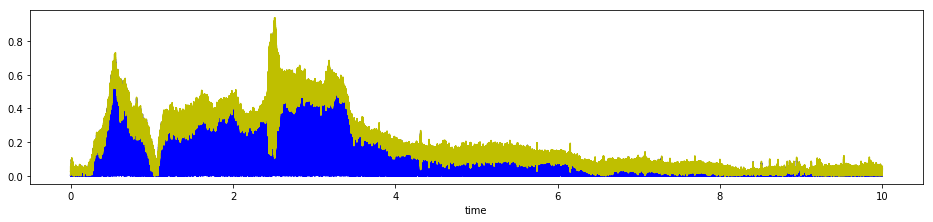

In [9]:
fig1 = figure(figsize=(width,height))
plot(t, abs(rcv_chirp), 'b', label = "rcv_signal")
plot(t, magnitude_enve, 'y', label = "analytic envelop")
plt.xlabel("time")

### Part I, Task IV: Auto-correlation Properties of the Chirp:

In part II of the lab, we will be sending and receiving chirp pulses to estimate delays between the tranceived pulses. This is done by cross correlating / matched filtering the received signal with the known chirp pulse to detect the echoes. In this task, we will investigate the correlation properties of the chirp.

A cross correlation is defined as:

$$ R_{xy}[n] = \sum_{m=-\infty}^\infty x[m]y^*[m-n] = (x[m]*y^*[-m])[n]$$

, where $y^*[-m]$ is the complex conjugat of $y[-m]$. This similar to a convolution, without flipping one of the signals. It can be implemented using a convolution as shown above. In general, the more correlated the two signals is at position $n$, the higher the value will be. That's why it is useful in a sonar system.

#### Matched filter 
When we look for a very specific shape in a signal, we can comput a cross correlation between the signal and the shape we are interested in. In that case, the operation of the cross correlation is also called a matched filter -- i.e. correlating with a filter that is matched to the shape we look for. 

Because we will be doing cross-correlations between a chirp pulse and its echoes, it is useful to look at the auto-correlation, which is basically a cross correlation of the signal with itself. A discrete autocorrelation of a signal is defined as: 

$$ R_{xx}[n] = \sum_{m=-\infty}^\infty x[m]x^*[m-n] = (x[m]*x^*[-m])[n]$$ 

The chirp has a very nice property that its auto-correlation is very narrow. Since the spread of the resulting correlation determines how fast you can detect, the width of the auto-correlation is important. This property is called pulse compression and is widely considered in radar design. Random noise and some other pseudo-random like sequences also possess this property. 

* Generate a 512 sample chirp pulse with a frequency sweep from 17KHz-18KHz and sampling rate fs=48000. 
* Validate its frequency response by plotting it.

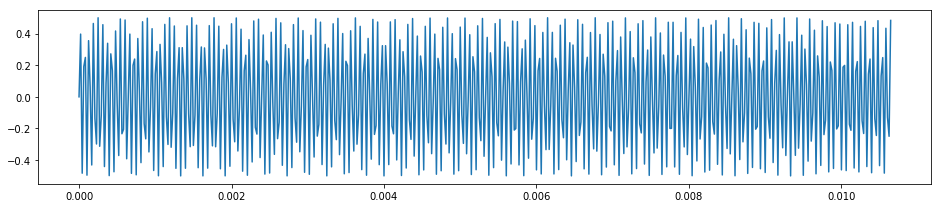

In [3]:
## Your beautiful code here:

# generate chirp signal
fs = 48000
f0 = 17000
f1 = 18000

# generate time index
T = 512 / fs
timeIndex = np.arange(0, T, 1/fs)
# generate chirp signal
k_f = (f1 - f0)/T
phi_of_t = 2*np.pi*np.multiply(timeIndex, ((k_f/2)*timeIndex + f0))
s_chirp = np.sin(phi_of_t) * 0.5

width, height = figaspect(0.2)
fig = figure(figsize=(width,height))
plt.plot(timeIndex, s_chirp)

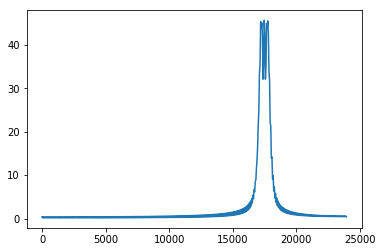

In [4]:
# generate frequency response of chirp
w, h = signal.freqz(s_chirp);

# generate frequency index

# Plot
width, height = figaspect(0.1)
plot(24000*w/np.pi, abs(h))


* Compute the autocorrelation of the chirp "using" discrete convolution, either with `signal.convolve` or `signal.fftconvolve`. Remember that you have to flip the signal since convolution does that already. You can flip a signal `x` by doing `x[::-1]`. Use mode=''full'' for convolution.
* Plot the autocorrelation. Your plot should be spiky because we did not do envolope detection yet. Use miliseconds as the x-axis

<IPython.core.display.Javascript object>


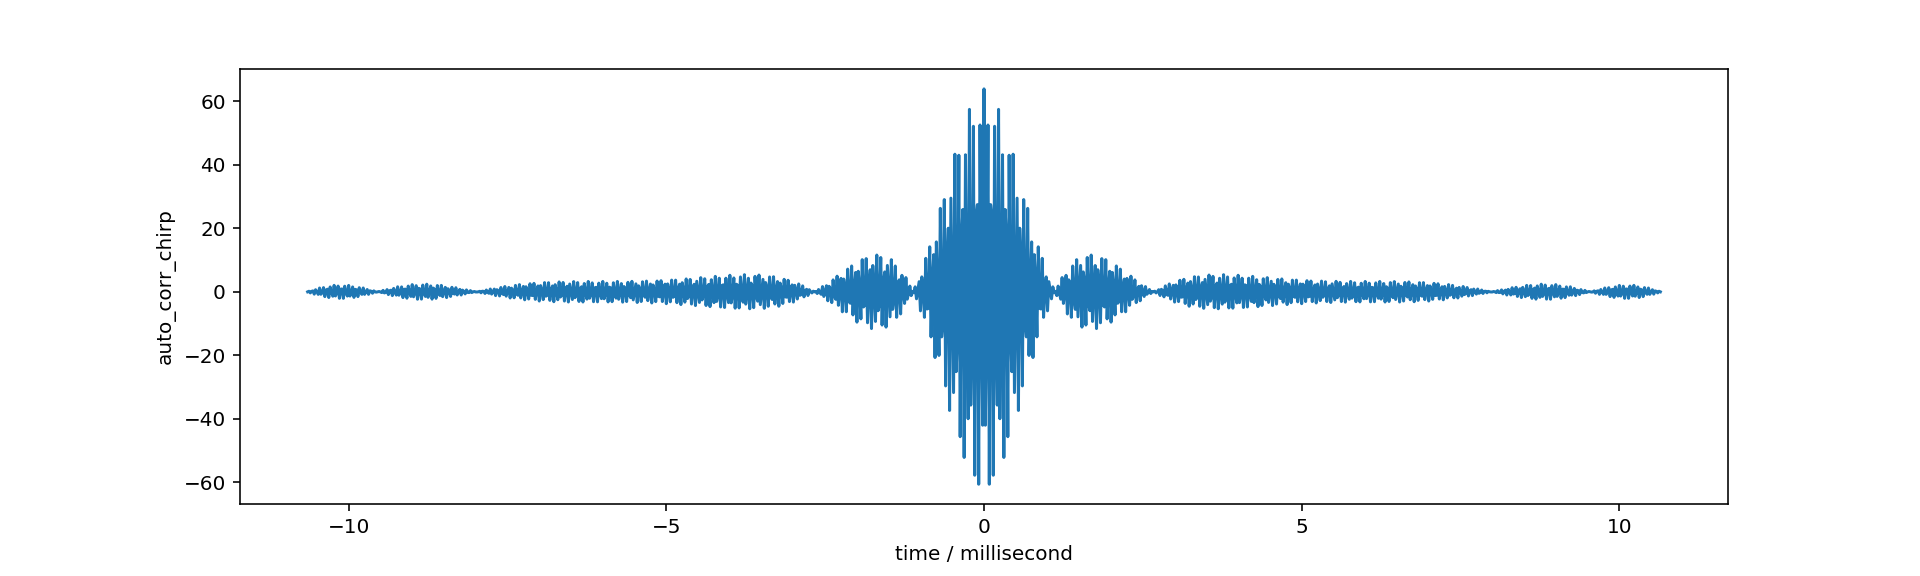

In [55]:
## Your fantastic code here:
auto_corr_chirp = signal.fftconvolve(s_chirp, np.conjugate(s_chirp[::-1]), mode = "full")
mill_s_index = np.append(-1000*timeIndex[::-1], timeIndex[1:]*1000)

width, height = figaspect(0.3)
# fig1 = figure()
plt.figure(figsize=(width,height))
plot(mill_s_index, auto_corr_chirp)
plt.xlabel("time / millisecond")
plt.ylabel("auto_corr_chirp")

In a similar way as we did before, it is possible to recover the envelope of the autocorrelation by performing a cross-correlation with the analytic signal and then taking the absolute value. In this case, we know exactly what is the analytic function is!

* Generate `s_chirp_a`, the analytic function of the chirp by computing: `s_chirp_a = exp(1j* phi_of_t )`. Perform cross correlation between `s_chirp_a` and `s_chirp` and show the envelope. As stated before, this could also be called a matched filter. 
* Measure the full-width at half max (FWHM) of the main lobe of the autocorrelation. 
* Comment on the FWHM of the main lobe of the matched-filter with respect to the length of the pulse. That ratio is also called pulse compression.  For simplicity, normalize the plot such that the maximum is 1, but record the maximum value of the autocorrelation and display it in the title of the figure.  

Use the pragma ``%matplotlib notebook`` for making the figure interactive, and ``plt.grid('on')`` for displaying a grid. 

Use miliseconds as the x-axis



<IPython.core.display.Javascript object>


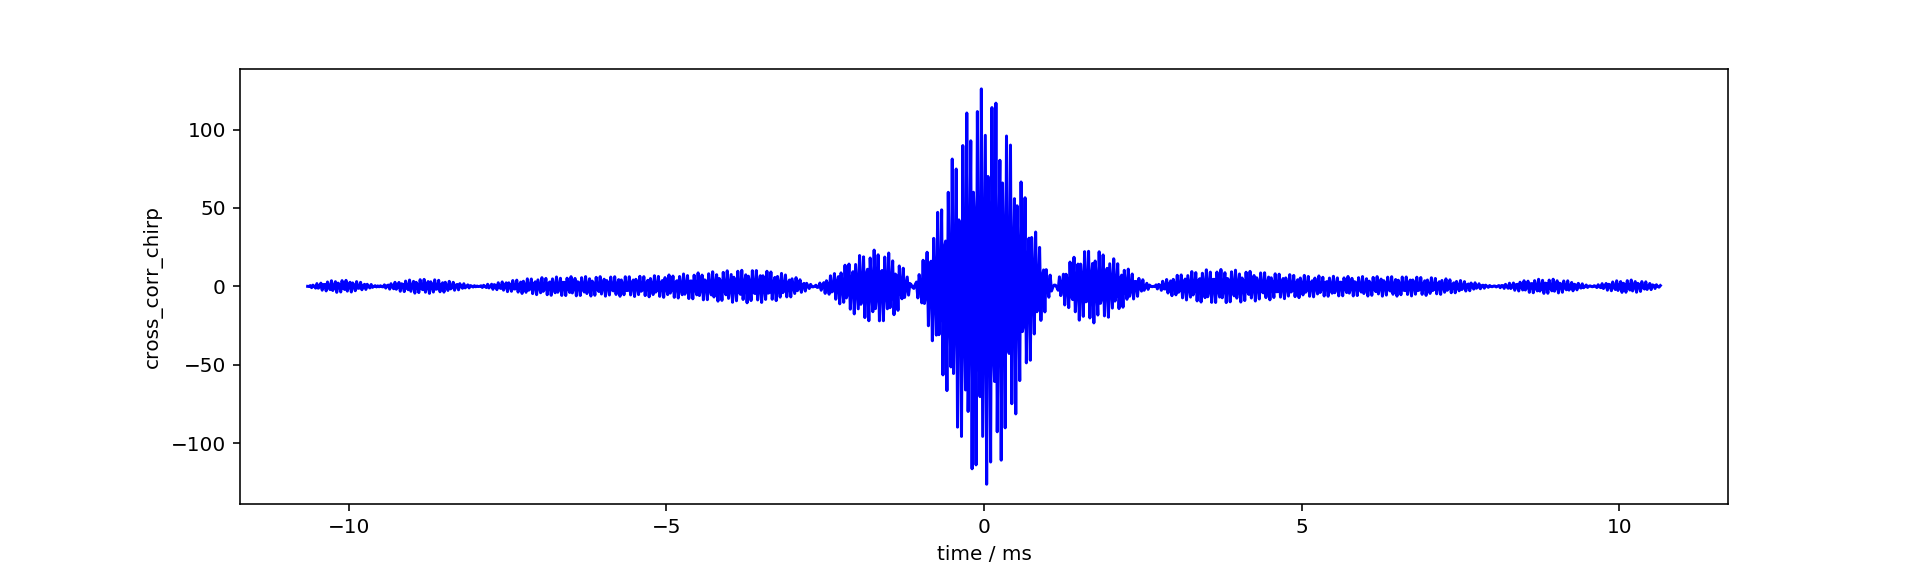

<IPython.core.display.Javascript object>


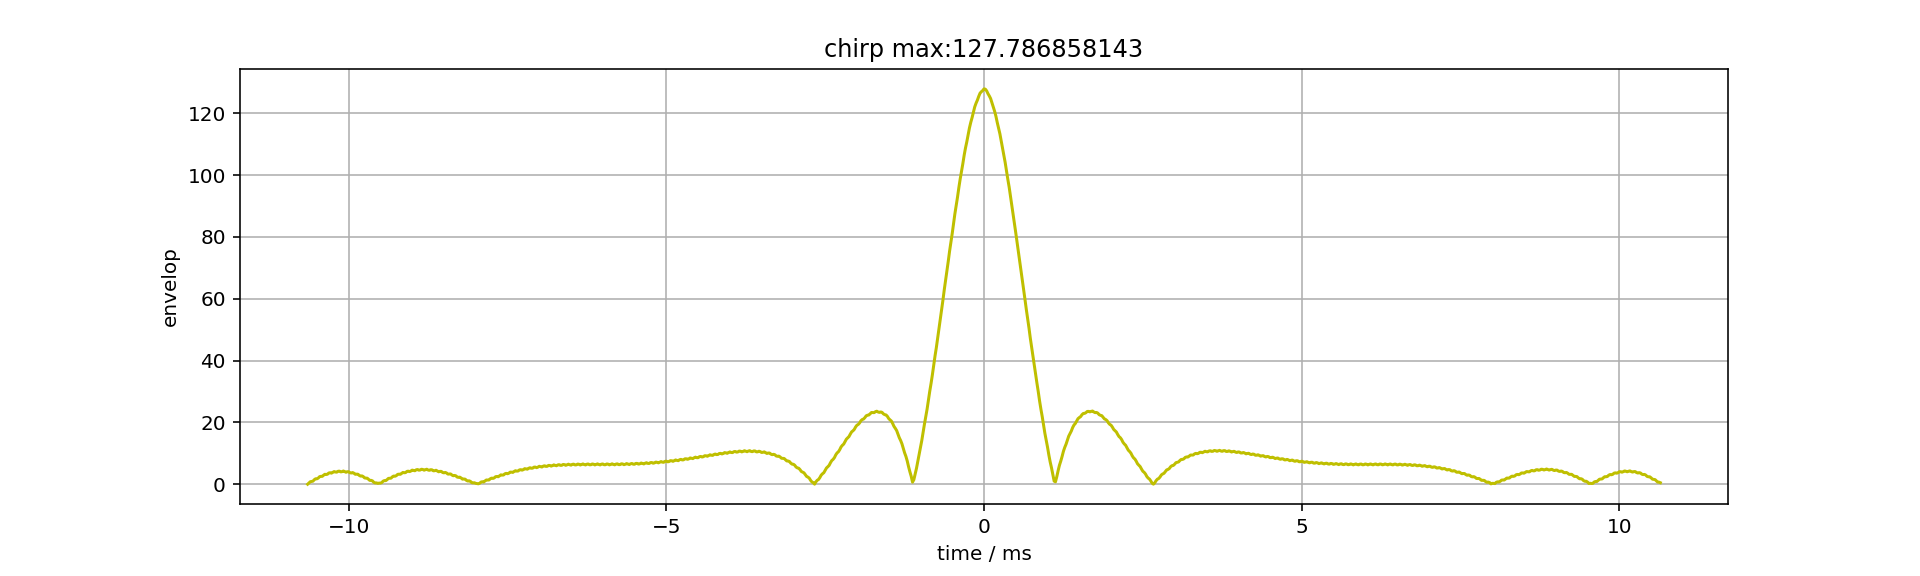

In [57]:
%matplotlib notebook
%matplotlib notebook

# your nice script to produce beautiful chirps, xcorralations and figures here:
s_chirp_a = exp(1j * phi_of_t)
# s_chirp_a = signal.hilbert(s_chirp)
x_corr_chirp = signal.fftconvolve(s_chirp, np.conjugate(s_chirp_a[::-1]), mode = "full")
mill_s_index = np.append(-1000*timeIndex[::-1], timeIndex[1:]*1000)

width, height = figaspect(0.3)
plt.figure(figsize=(width,height))
plot(mill_s_index, x_corr_chirp, 'b')
plt.xlabel("time / ms")
plt.ylabel("cross_corr_chirp")

plt.figure(figsize=(width,height))
# analytic_x_corr_chirp = signal.hilbert(real(x_corr_chirp))
# abs_c = abs(analytic_x_corr_chirp)
# plot(mill_s_index, abs_c/max(abs_c), 'y')
plot(mill_s_index, abs(x_corr_chirp), 'y')
plt.xlabel("time / ms")
plt.ylabel("envelop")

# title and stuff
title = "chirp max:" + str(max(abs_c))
plt.title("%s"% title)
plt.grid('on')

#### Your answer here:
Using the interactive cursor, we can get a FWHM of approximate 11.6 ms
/#todo

Now we will look at why the chirp pulse is better for cross-correlation detection than a pure tone.
- Repeat Task "III" <- "IV" for:
 1. A constant frequency of 17000Hz, 512 samples in length. 
 2. A chirp with a frequency sweep from 16500Hz - 17500Hz (1KHz Bandwidth), 512 in length.  
 3. A chirp with a frequency sweep from 15000Hz - 19000Hz (4KHz Bandwidth), 512 in length
- Compare the size of the main lobes (full width at half max). How much "Pulse Compression" are you getting by using a chirps for detection compared to a single frequency pulse?
- What is the approximate bandwidth of the pure frequency pulse and what is the bandwidth of the chirp pulses? Comment on the tradeoff between bandwidth and pulse compression
- What is the maximum autocorrelation for each pulse?


   

<IPython.core.display.Javascript object>


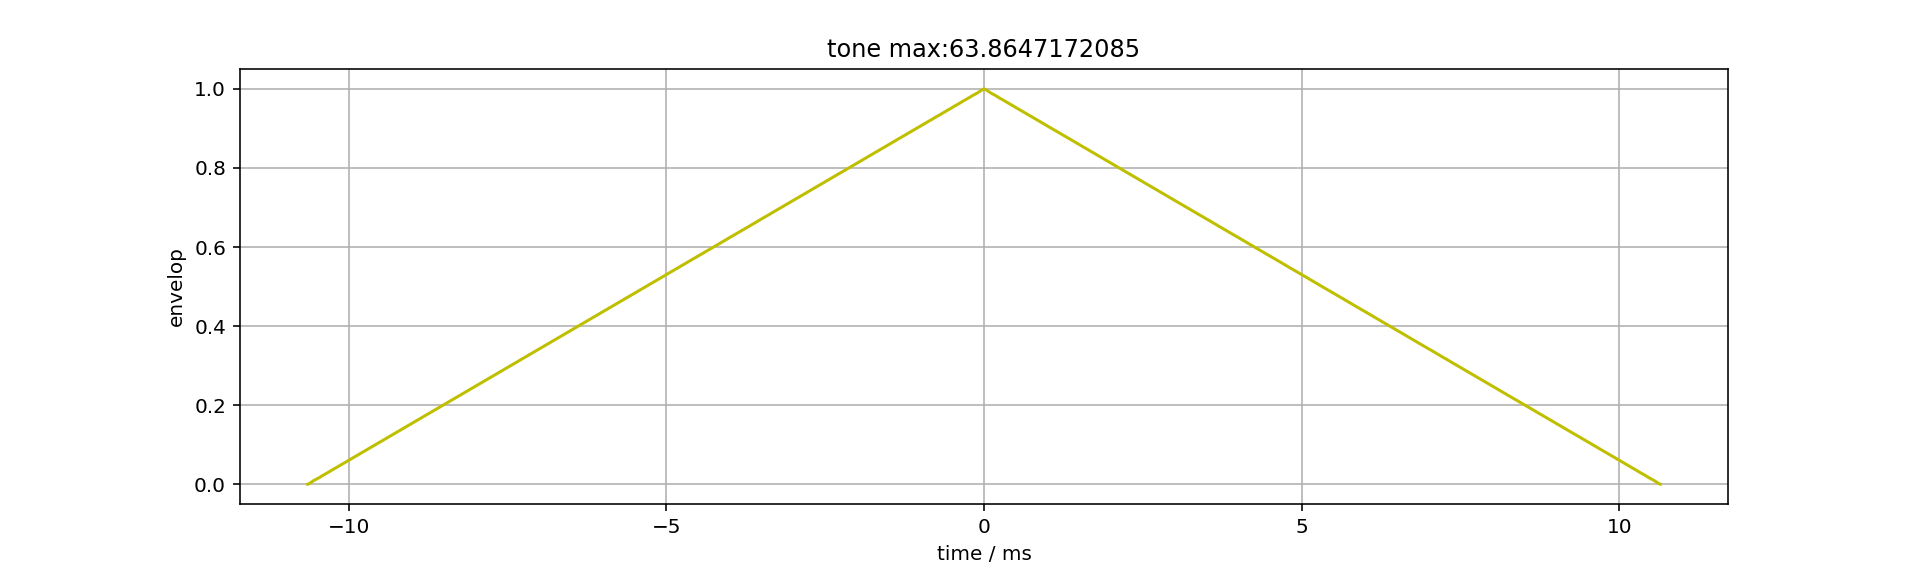

<IPython.core.display.Javascript object>


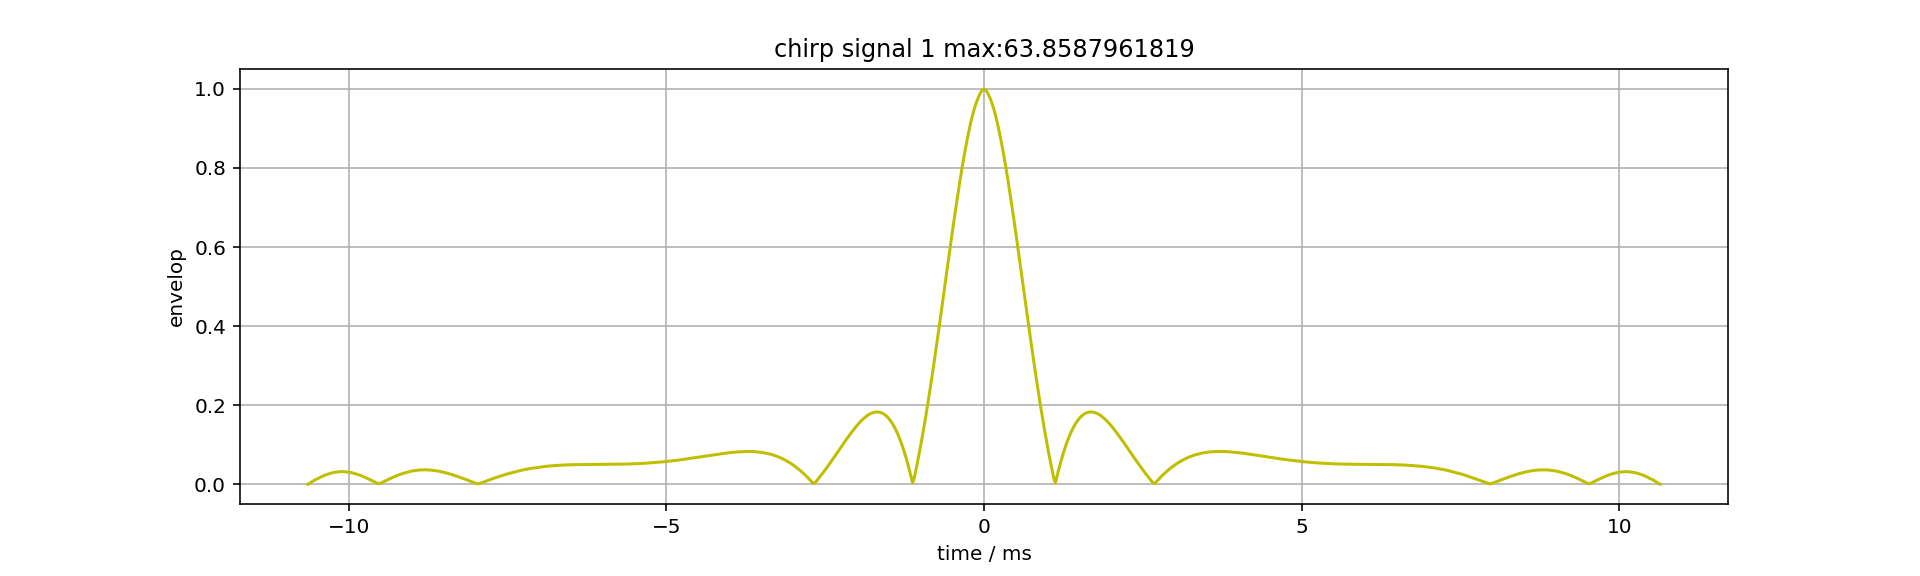

<IPython.core.display.Javascript object>


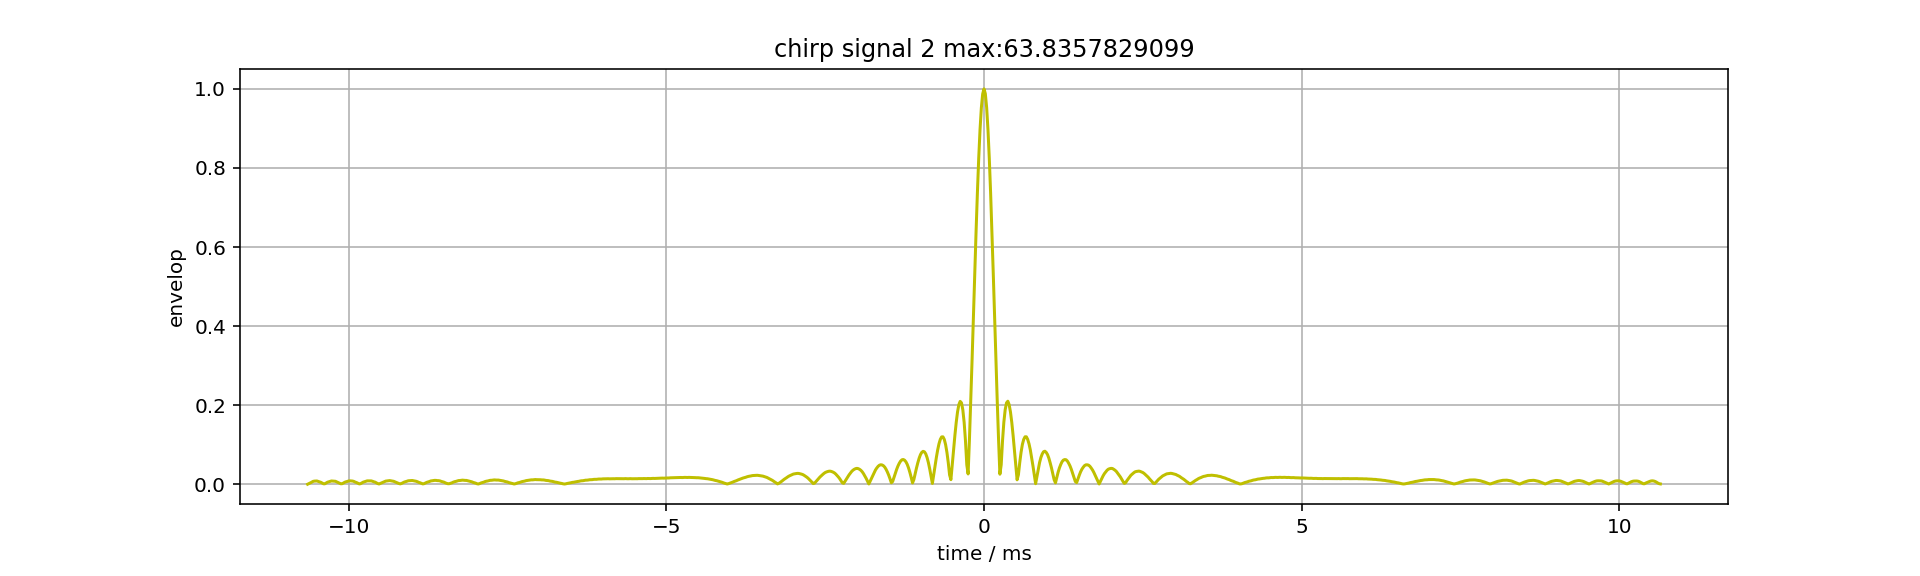

In [58]:
fs = 48000
sample_no = 512
T = sample_no/fs
t = r_[0.0:sample_no]/fs

def createChirp(f0, f1, fs, sample_no):
    T = sample_no/fs
    t = r_[0.0:sample_no]/fs
    k_f = (f1-f0)/T
    phi_of_t = 2*np.pi*np.multiply(t, ((k_f/2)*t + f0))
    return np.sin(phi_of_t) * 0.5

def createChirpA(f0, f1, fs, sample_no):
    T = sample_no/fs
    t = r_[0.0:sample_no]/fs
    k_f = (f1-f0)/T
    phi_of_t = 2*np.pi*np.multiply(t, ((k_f/2)*t + f0))
    return exp(1j * phi_of_t)

def dispEnv(sig, t, title):
    
    sig_a = signal.hilbert(sig)
    x_corr_sig = signal.fftconvolve(sig, np.conjugate(sig_a[::-1]), mode = "full")
    mill_s_index = np.append(-1000*t[::-1], t[1:]*1000)
    
    # config plot
    width, height = figaspect(0.3)
    plt.figure(figsize=(width,height))
    plt.xlabel("time / ms")
    plt.ylabel("envelop")
    
#     analytic_x_corr_sig = signal.hilbert(real(x_corr_sig))
#     abs_c = abs(analytic_x_corr_sig)
#     plot(mill_s_index, abs_c/max(abs_c), 'y')

    abs_x = abs(x_corr_sig)
    plot(mill_s_index, abs_x/max(abs_x), 'y')    
    
    # config plot
    title = title + " max:" + str(max(abs_x))
    plt.title("%s"% title)
    plt.grid('on')
    

# def dispEnv(f0, f1, fs, sample_no, title):
#     T = sample_no/fs
#     t = r_[0.0:sample_no]/fs
#     chirp = createChirp(f0, f1, fs, sample_no)
#     chirp_a = createChirp(f0, f1, fs, sample_no)
#     x_corr_chirp = signal.fftconvolve(chirp, np.conjugate(chirp_a[::-1]), mode = "full")
#     mill_s_index = np.append(-1000*t[::-1], t[1:]*1000)
    
#     width, height = figaspect(0.3)
#     plt.figure(figsize=(width,height))
    
#     analytic_x_corr_chirp = signal.hilbert(real(x_corr_chirp))
#     abs_c = abs(analytic_x_corr_chirp)
#     plot(mill_s_index, abs_c/max(abs_c), 'y')
#     plt.xlabel("time / ms")
#     plt.ylabel("envelop")
    
#     title = title + " max:" + str(max(abs_c))
#     plt.title("%s"% title)
#     plt.grid('on')

tone = createChirp(17000, 17000, fs, sample_no)
chi_1 = createChirp(16500, 17500, fs, sample_no)
chi_2 = createChirp(15000, 19000, fs, sample_no)

# Plot
dispEnv(tone, t, "tone")
dispEnv(chi_1, t, "chirp signal 1")
dispEnv(chi_2, t, "chirp signal 2")


#### Your answers and interpretations here:


\# todo

- Now, repeat task "III" <- "IV" for 
 1. a chirp with a frequency sweep from 16500Hz - 17500Hz, 256 in length

- Compare the size of the main lobe (full width at half max) to the previous case of  16500Hz - 17500Hz, 512 in length.
- Compare the maximum autocorrelation as well. 

What's the effect of having more bandwidth? what's the effect of having longer/shorter pulses?



<IPython.core.display.Javascript object>


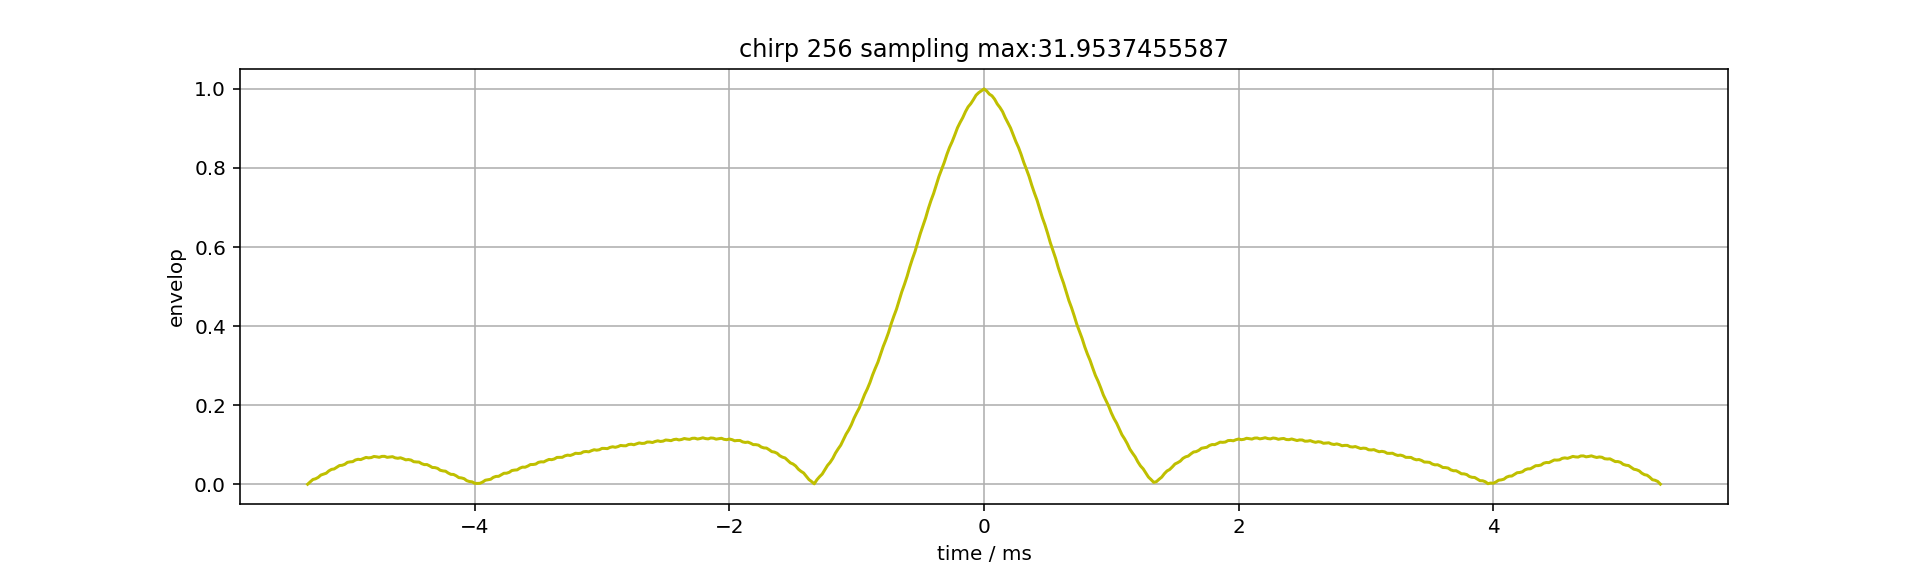

In [59]:
fs = 48000
sample_no = 256
T = sample_no/fs
t = r_[0.0:sample_no]/fs

# generate chirp signal
chi_1_1 = createChirp(16500, 17500, fs, sample_no)
dispEnv(chi_1_1, t, "chirp 256 sampling")

####  Your answer below:
\# todo


### Dealing with sidelobes
As you can see, the chirp provides good pulse compression of the main-lobe. However, there exists very strong sidelobes. This is because the chirp is multiplied with a rect function, that is abrupt. Instead, we will window the chirp with one of the smooth window functions to taper off the sidelobes. 
    

* Repeat the above for a chirp with a sweep from 16.5KHz to 17.5KHz, and from 15KHz to 19KHz. This time, multiply the chirp (and its analytic function) with a hanning window.  You will find the function `np.hanning` useful. 

* plot the normalized autocorrelations (in the same figure) 
* Comment on the magnitude of the side-lobes? 
* Comment on the width of the main lobes? 
* What's the tradeoff?


<IPython.core.display.Javascript object>


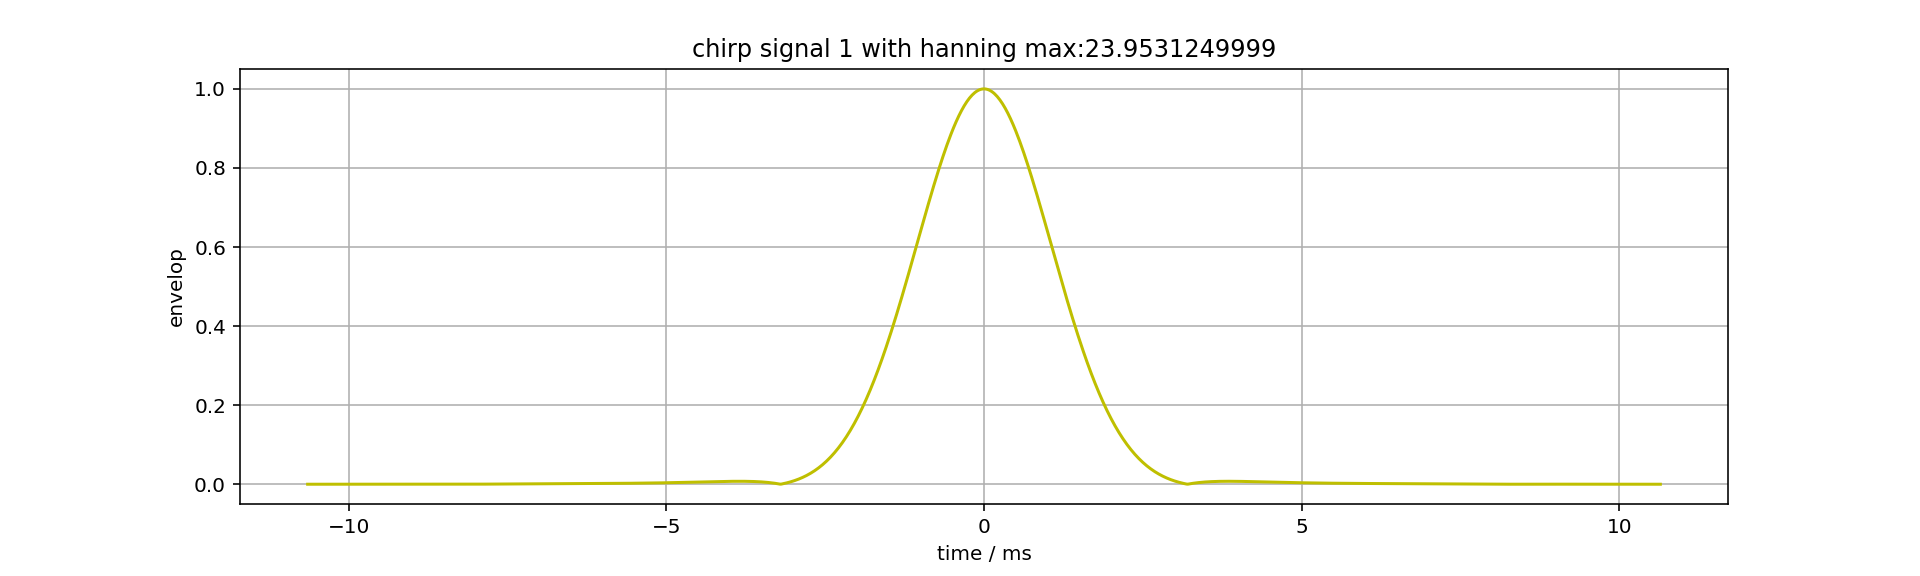

<IPython.core.display.Javascript object>


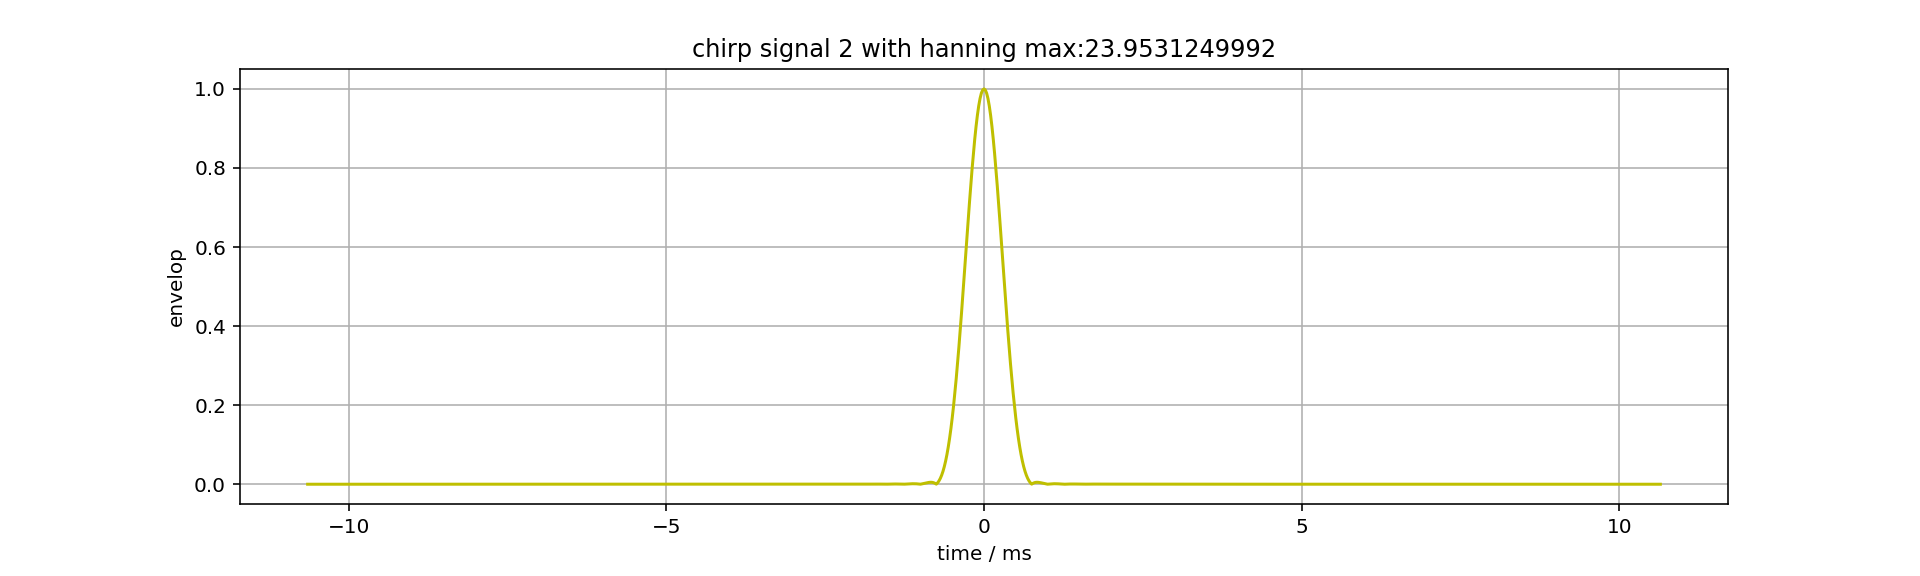

In [60]:
# your solution here
samples = 512
fs = 48000
t = r_[0.0:samples]/fs

ch_1_ = createChirp(16500, 17500, fs, samples)
ch_2_ = createChirp(15000, 19000, fs, samples)

han_win = np.hanning(samples)
ch_1_han = np.multiply(ch_1_, han_win)
ch_2_han = np.multiply(ch_2_, han_win)


dispEnv(ch_1_han, t, "chirp signal 1 with hanning")
dispEnv(ch_2_han, t, "chirp signal 2 with hanning")


#### Your answers here:
to do: add function for computing main lope



### You are now ready to proceed to the Sonar Lab

## Part 2: Sonar

In this part of the lab we will write a simple application that implements a sonar using the RaspberryPi, speaker and microphone. 

The basic idea is very simple and is the basis of sonar and ultrasound images -- Objects reflect sound waves. If we send a pulse of sound, we will get reflection echoes of that pulse. Detecting the echos and their time-of-flight will reveal their distance from the source, based on the speed of sound in air. 

The way we are going to implement the sonar is to generate a series of rapid pulses, and use matched filtering to detect the source and the returning echos. There are many parameters in this lab that can be tweaked to get different results. We encourage you to experiment. We enjoyed very much making the lab and played quite a bit! We hope you enjoy it too. 

#### Instructions for RaspberryPi:
The microphone and speaker you have are somewhat directional. Make sure that the microphone and speaker point in the same direction. You will get the best quallity in a quiet room, without interference from other sources of noise -- especially from your fellow students playing chirp pulses at the same time as you are!

If you are getting poor results, please consult with us. 

This lab was inspired from an iphone app called active-radar. 






### Part II, Task I: Generating Chirp Pulses

Recall from Part I, that the width of the main lobe of the autocorrelation depends on the bandwidth of the pulse. 
For a constant frequency pulse, the bandwidth will be inversly proportional to its length. Short pulses are localized in time, and therefore we will be able to separate echoes from targets that are close. However, short pulses carry less energy (for the same amplitude) and this will reduce our signal to noise ratio (SNR) in the detection and reduce our ability to detect the targets at all. So, in summary: for constant frequency pulse, there's an inerent tradeoff between the resolution of the sonar (distinguish between close targets) and the signal to noise ratio. 

If we use a chirp pulse, we can increase the length of the pulse while also increasing the bandwidth. This will enable us to improve our signal to noise ratio as well as keeping the resolution of our sonar (by preserving the BW).

In our implemetation we are going to design a pulsed sonar system in which we repeatedly send pulses and then listen to the returning echoes. The arrival time of the echos will correspond to double the time-of-flight of sound propagation from our system to the target. 

* Write a function that generates a chirp pulse:
`pulse = genChirpPulse(Npulse, f0, f1, fs)` 

The function will accept: `Npulse` = number of samples, `f0,f1` = starting and ending frequency and `fs` = sampling frequency. The function will return the analytic function of the chirp $\exp (j 2\pi \int_0^t f(t)dt )$ with amplitude 1.

In [10]:
def genChirpPulse(Npulse, f0, f1, fs):
    #     Function generates an analytic function of a chirp pulse
    #     Inputs:
    #             Npulse - pulse length in samples
    #             f0     - starting frequency of chirp
    #             f1     - end frequency of chirp
    #             fs     - sampling frequency
    #     Output:
    #              pulse - chirp pulse
    
    T = Npulse/fs
    t = r_[0.0:Npulse]/fs
    k_f = (f1-f0)/T
    phi_of_t = 2*np.pi*np.multiply(t, ((k_f/2)*t + f0))
    return exp(1j * phi_of_t)
    


* To validate that the function works display the pulse generated with Npulse = 200, f0=1000, f1 = 8000, fs = 48000. Remember the pulse is complex, so plot the real and imaginary part separately.

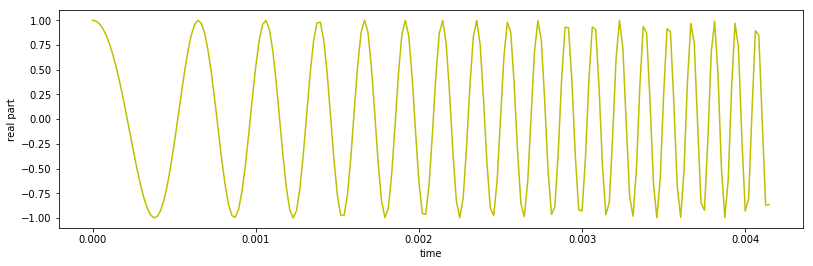

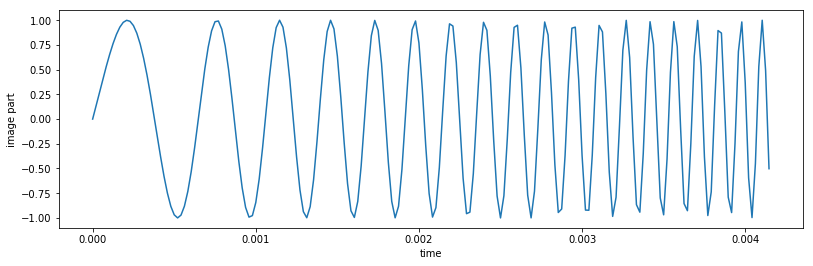

In [11]:
%matplotlib inline
%matplotlib inline
pulse = genChirpPulse(200, 1000, 8000, 48000)

# your code here:
r = pulse.real
i = pulse.imag
t = r_[0.0:200]/48000
# plot
width, height = figaspect(0.3)
plt.figure(figsize=(width,height))
plot(t, r, 'y')
plt.xlabel("time")
plt.ylabel("real part")
plt.figure(figsize=(width,height))
plot(t, i)
plt.xlabel("time")
plt.ylabel("image part")

__Generate Pulse Trains__

Next, we will use the pulse generated by `genChirpPulse` and generate a pulse train.

* Write a new function `ptrain = genPulseTrain(pulse, Nrep, Nseg)`
The function accepts `pulse` = a pulse generated by `genChirpPulse`,  `Nrep` = number of pulse repetitions and `Nseg` = length of each pulse train segment (which is >= to the length of `pulse`).

The function returns `ptrain` which is a vector of length `Nrep` x `Nseg` (Hint: use `np.tile`)

In [12]:
def genPulseTrain(pulse, Nrep, Nseg):
    # Funtion generates a pulse train from a pulse. 
    #Inputs:
    #    pulse = the pulse generated by genChirpPulse
    #    Nrep  =  number of pulse repetitions
    #    Nseg  =  Length of pulse segment >= length(pulse)
    
    # error handling
    pulse_padding = np.append(pulse, np.zeros(Nseg - len(pulse)))
    ptrain = np.tile(pulse_padding, Nrep)
    return ptrain

### Part II, Task II: Echos in with Chirp pulse train

We now have components to generate pulses, generate a pulse train, play and record it. Lets see what we get!
We will start with very short pulses with a single carrier frequency. Rectangular pulses are difficult for the speaker
to produce as they exhibit discontinuities in the beginning and the end of the pulse. Therefore we will multiply the pulses
with a smooth window. Here, we will use a hanning window.

* Generate a f0=f1=8KHz, Npulse=96 pulse with fs=48000. Window the pulse with a hanning window. This will result in a pulse length of 2ms. You should be able to hear this tone.
* Plot the real and imaginary part of the pulse

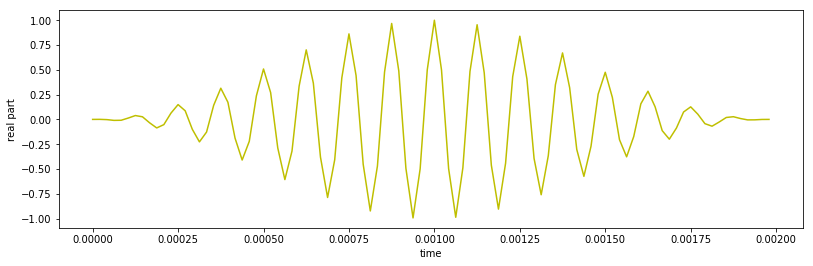

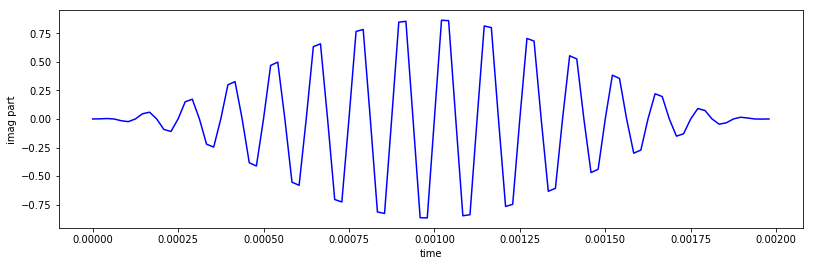

In [13]:
fs = 48000
f0 = 8000
f1 = 8000
Npulse = 96

# help function
def genTimeIndex(Npulse, fs):
    return np.r_[0.0:Npulse]/fs

def newFig(x, y, ratio, xl, yl, color):
    width, height = figaspect(ratio)
    plt.figure(figsize=(width,height))
    plot(x, y, color)
    plt.xlabel(xl)
    plt.ylabel(yl)
    
def fig(y, ratio, xl, yl):
    width, height = figaspect(ratio)
    plt.figure(figsize=(width,height))
    plot(y)
    plt.xlabel(xl)
    plt.ylabel(yl)
    
t = genTimeIndex(Npulse, fs)
# your code here:
c_pulse = genChirpPulse(Npulse, f0, f1, fs)
han_win = np.hanning(Npulse)
pulse_smooth = np.multiply(c_pulse, han_win)

newFig(t, pulse_smooth.real, 0.3, "time", "real part", 'y')
newFig(t, pulse_smooth.imag, 0.3, "time", "imag part", 'b')

* Use the real part of the pulse to generate a pulse train of Nrep=15 pulses, Nseg=4096 samples

In [39]:
Nrep=15
Nseg=4096
ptrain = genPulseTrain(pulse_smooth.real, 15, 4096)

* Play and record the pulse train. Scale the amplitude of the pulses to 1/2. Make sure your volume is set to maximum of 70% and look at the plot with the input pulse train and the received pulse train.

Use the pragma ``%matplotlib notebook`` for interactive plots, so you can zoom into the result.

In [15]:
!amixer -c 1 -- sset Lineout playback  100%,0%
!amixer -c 1 -- sset Mic capture  67%
!amixer -c 1 -- sset Mic playback  59%

Simple mixer control 'Lineout',0
  Capabilities: pvolume pswitch pswitch-joined
  Playback channels: Front Left - Front Right
  Limits: Playback 0 - 31
  Mono:
  Front Left: Playback 31 [100%] [0.00dB] [on]
  Front Right: Playback 0 [0%] [-15.50dB] [on]
Simple mixer control 'Mic',0
  Capabilities: volume volume-joined
  Playback channels: Mono
  Capture channels: Mono
  Limits: 0 - 3
  Mono: 3 [100%] [40.00dB]
Simple mixer control 'Mic',0
  Capabilities: volume volume-joined
  Playback channels: Mono
  Capture channels: Mono
  Limits: 0 - 3
  Mono: 2 [67%] [30.00dB]


In [16]:
rcv = sd.playrec(ptrain/2.0, fs, channels=1,blocking=True)
rcv = rcv.reshape((rcv.shape[0],))

<IPython.core.display.Javascript object>


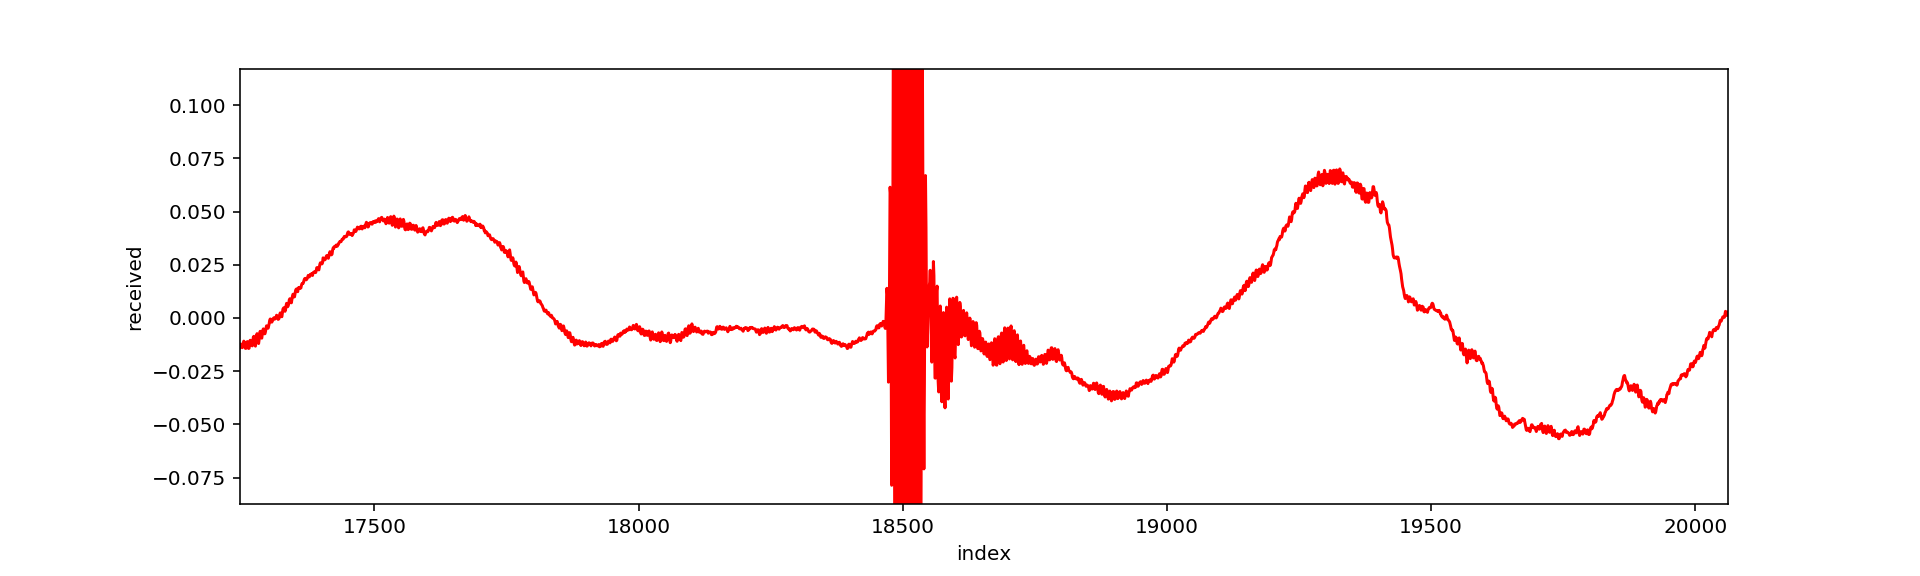

<IPython.core.display.Javascript object>


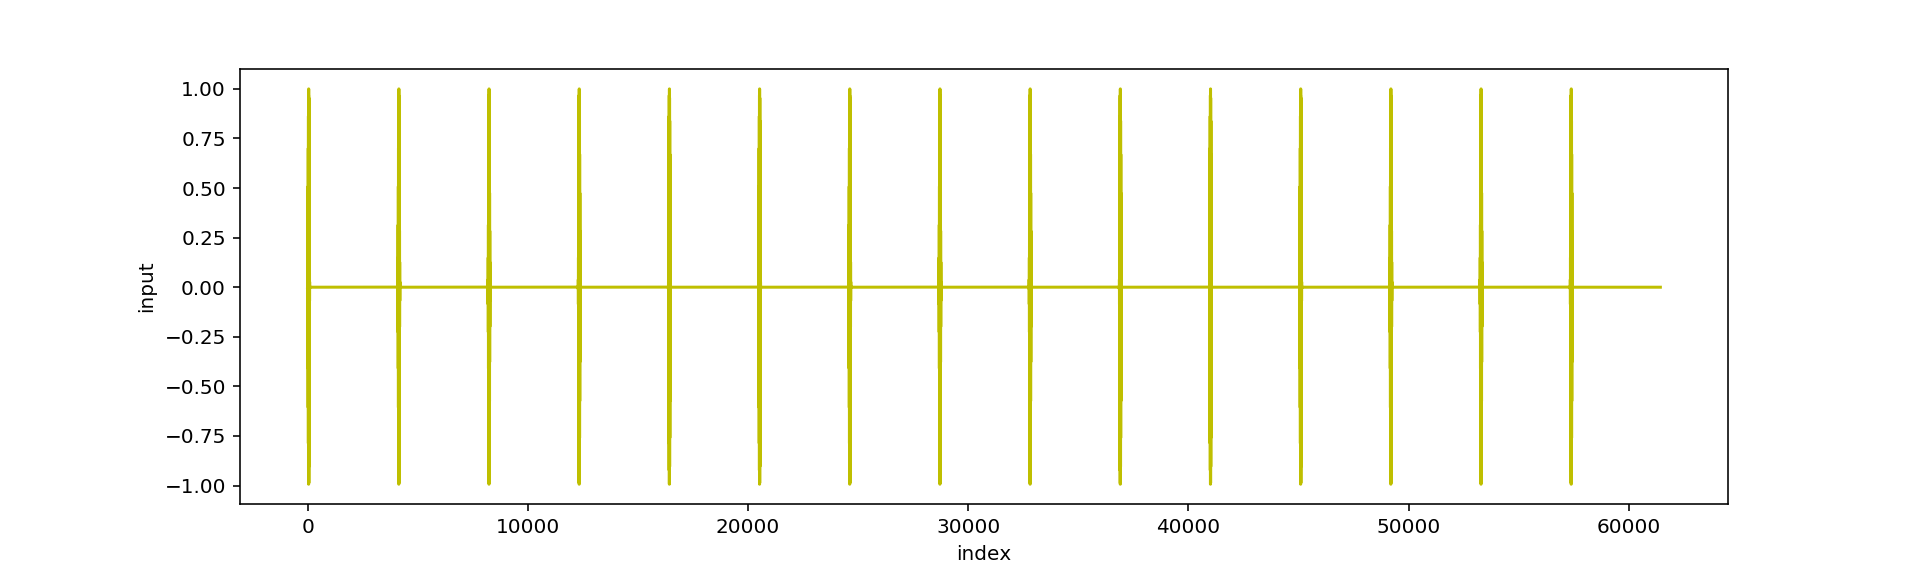

In [26]:
%matplotlib notebook
# %matplotlib notebook

# t_ = genTimeIndex(4096*15 ,fs)
index = np.r_[0:4096*15]
newFig(index, rcv, 0.3, "index", "received", 'r')
newFig(index, ptrain, 0.3, "index", "input", 'y')

* Extract a single pulse from the received pulse train. You can find the pulse index from the interactive plot. Extract at least 2 Npulse samples before the pulse and 20 Npulse samples after using `rcv_pulse = rcv[idx-2*Npulse:idx+Npulse*20]` 

* Plot the received pulse. Can you see any echoes?

You can disable interactivity by the pragma ``matplotlib inline``


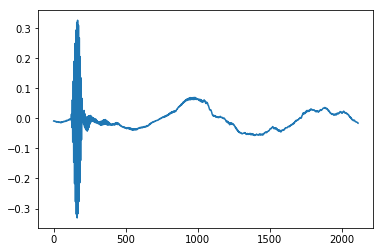

In [27]:
%matplotlib inline

# your code here:
# find index of start pulse
idx = 18539 # random
rcv_pulse = rcv[idx-2*Npulse:idx+Npulse*20]

# your code here:
# Plot
plot(rcv_pulse)

#### Matched Filtering

The strong pulses we see are a result of direct feed-through from the transmitter to the receiver that do not scatter off targets. The echoes we see are a result of echoes from reflecting surfaces. The problem in our setup is that we don't know the exact delay between the transmitter and the receive hardware. Instead, we will assume that the travel time for sound between the speaker and the microphone is negligible and much smaller than scatering targets. We can then detect when the pulses start based on the direct feedthrough signal. This assumption is very good as long as your speaker is close to the microphone!

We will detect both the feedthrough and echoes using matched filtering. 

* Write a function `Xrcv = crossCorr( rcv, pulse_a )` to calculate the cross correlation (matched filter) of the received signal with the analytic function of the pulse.  You can use `signal.fftconvolve`
* Take the absolute value of `Xrcv` to recover its envelope. Call the result `Xrcv_a`.

Make sure the plot is interactive with ``matplotlib notebook``

In [28]:
def crossCorr( sig, pulse_a ):
    # Funtion generates cross-correlation between rcv and pulse_a
    # Inputs:
    #    rcv - received signal
    #    pulse_a - analytic pulse
    # Output:
    #    Xrcv - cross-correlation between rcv and pulse_a
    return signal.fftconvolve(sig, pulse_a, mode = "full")

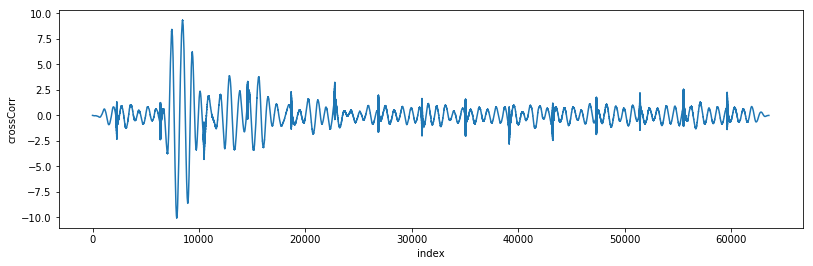

In [29]:
%matplotlib inline

# your code here:
Xrcv = crossCorr(rcv, rcv_pulse)
fig(Xrcv, 0.3, "index", "crossCorr")


In [36]:
Xrcv_a = abs(Xrcv)

* Again, extract a single pulse from the received pulse train using the same index. Extract at least 2 Npulse samples before the pulse and 20 Npulse samples after. Plot the received pulse. Can you see any echoes?

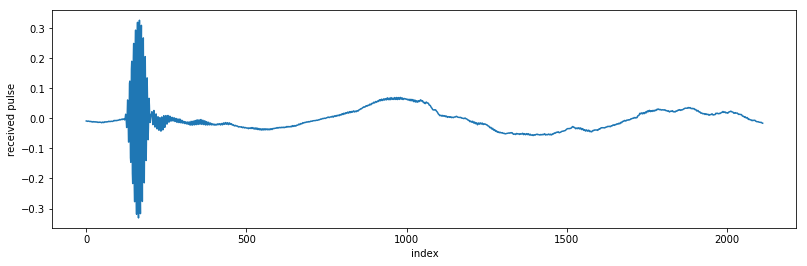

In [31]:
%matplotlib inline
# find index of start pulse
idx = 18539 # random
# Plot
rcv_pulse_ = rcv[idx-2*Npulse:idx+Npulse*20]

fig(rcv_pulse, 0.3, "index", "received pulse")

#### Sonar System

In order to automate the system and visualize the results we need a few more components. To extract the pulses we need to know the position of the first feedthrough pulse. 


* Write a function `idx = findDelay(Xrcv_a, Nseg)` that takes the result of the matched filtering and finds the index of the first feedthrough pulse. Try testing on the actual signal to check whether the function is correct. There are multiple ways of doing it. `Nseg` is not necessarily required.

In [42]:
def findDelay(Xrcv, Nseg):
    # finds the first pulse
    # Inputs:  
    #         Xrcv - the received matched filtered signal
    #         Nseg - length of a segment
    # Output:
    #          idx - index of the beginning of the first pulse
    abs_x = abs(Xrcv)
    peak = max(abs_x[:Nseg])
    for i in range(Nseg):
        if Xrcv[i] == peak:
            return i
    

In [43]:
idx = findDelay(Xrcv_a,Nseg)
print(idx)


2285


We now can correct for delays and detect echoes. The only thing left now is to convert the time between echoes into actual distance.

If we send a pulse of sound, we will get reflection echoes of that pulse. Detecting the echos and their time-of-flight will reveal their distance from the source, based on the speed of sound in air. The speed of sound in air is given by the following equation:

$$ v_s = 331.5\sqrt{1+T/273.15}~\mathrm{m/s}~,$$ 

where T is the temperature in degree celcius. 

* Create a function `t = dist2time( dist, temperature )` that takes in the distance to the target in cm and converts it into the time in seconds between the transmitted pulse and its echo. Remember the arrival time include the time to the target and back and therefore the time should be doubled. 
For example, for temperature = 20 celcius and dist = 400 cm, the time it takes is 0.023 secs.

* Create a function `dist = time2dist( t, temperature )` that takes in the time to the target in seconds and converts it into the distance in cm between the transmitted pulse and its echo. Remember the arrival time include the time to the target and back and therefore the time should be halfed. 

In [45]:
def dist2time( dist, temperature=21):
    # Converts distance in cm to time in secs
    # Inputs:
    # dist        - distance to object in cm
    # temperature - in celcius
    # Output:
    # t           - time in seconds between transmitted pulse and echo
    v=331.5*sqrt(1+temperature/273.15)
    t=dist/v*2
    return t


def  time2dist(t,temperature=21):
    # Converts time in seconds to distance in cm
    # Inputs:
    # t        - time of echo
    # temperature - in celcius
    # Output:
    # dist          - distance in cm of the target
    v=331.5*sqrt(1+temperature/273.15)
    dist=t*v*100/2
    return dist


## A sonar (almost)

* The following function will use your functions to generate pulses and display the matched filtering of each pulse as intensity of a horizontal line in an image. If nothing is moving, you will be able to see constant vertical lines representing echos. If something is moving, you will be able to track the object's distance.  



In [46]:
def sortOfASonar(Npulse, f0, f1,fs, Nrep, Nseg):
    pulse_a = genChirpPulse(Npulse, f0, f1, fs)*np.hanning(Npulse)
    pulse = pulse_a.real
    ptrain = genPulseTrain(pulse, Nrep, Nseg)
    rcv = sd.playrec(ptrain/2.0, fs, channels=1,blocking=True)
    rcv = rcv.reshape((rcv.shape[0],))
    Xrcv_a = abs( crossCorr(rcv, pulse_a) )
    
    idx = findDelay(Xrcv_a,Nseg) 
    img = np.zeros((Nrep-1,Nseg))
    img[0,:]=Xrcv_a[idx:idx+Nseg]
    
    # Look for peak in each pulse in the pulse train to avoid drift between xmit and receive
    for n in range(1,Nrep-1):
       idxx = findDelay(Xrcv_a[idx+Nseg//2:idx+Nseg//2+Nseg],Nseg)
       idx = idx + idxx+Nseg//2
       img[n,:]=Xrcv_a[idx:idx+Nseg]
        
    
    return img

Now, use the function above to:  

* Generate a pulse train of 100 pulses. Each (hamming windowed) pulse should be length of 72 samples (1.5ms) and constant frequency of 8KHz. The spacing between puslses should be 0.1 seconds (Nseg=4800). 
* Display the image

In [47]:
Npulse = 72
f0 = 8000
f1 = 8000
fs = 48000
Nrep = 100
Nseg = 4800
img = sortOfASonar(Npulse, f0, f1,fs, Nrep, Nseg)

Display the result. Pay attention to the width of the echos. 

<IPython.core.display.Javascript object>


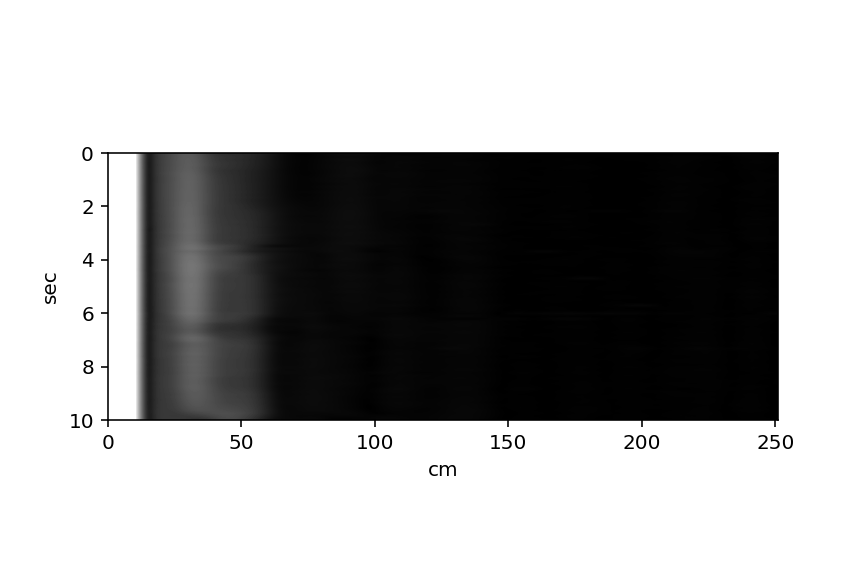

In [48]:
%matplotlib notebook
%matplotlib notebook

# display up to 2.5m approximately 700 samples at 21 degrees C in 48000 sampling rate

vmax = 0.3 # threshold -- lower will be able to see smaller echos

plt.imshow(img[:,0:700]/max(img.ravel()),vmax=vmax, aspect=10,cmap='gray',interpolation='bilinear',extent=(0,time2dist(700/48000),Nrep*Nseg/fs,0))
plt.xlabel('cm')
plt.ylabel('sec')

Now, repeat the experiment with a chirp length of Nseg = 360 samples, and a frequency sweep from 6KHz to 12KHz.
Pay attention to the resolution of the lines. 

In [49]:
Npulse = 72*5
f0 = 6000
f1 = 12000
fs = 48000
Nrep = 100
Nseg = 4800
img = sortOfASonar(Npulse, f0, f1,fs, Nrep, Nseg)

<IPython.core.display.Javascript object>


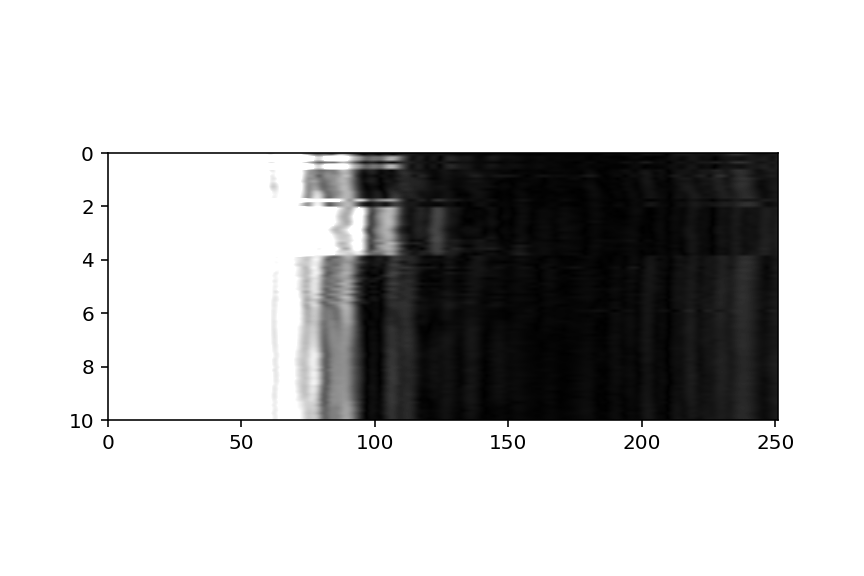

In [50]:
%matplotlib notebook

# display up to 2.5m approximately 700 samples at 21 degrees C in 48000 sampling rate

vmax = 0.3 # threshold -- lower will be able to see smaller echos

plt.imshow(img[:,0:700]/max(img.ravel()),vmax=0.2, aspect=10,cmap='gray',interpolation='bilinear',extent=(0,time2dist(700/48000),Nrep*Nseg/fs,0))


Feel free to repeat while moving a target-- can you see the echoes changing? Try playing with different parameters. 




## A Real (time) Sonar
You now have a working sonar! It would be much easier though to play with different parameters if we automate things, so we created some wrappers for real-time plotting in a separate notebook (lab1-RealTime-Sonar). 

* Copy-and-paste the 5 functions you created, including genPulseTrain(), genChirpPulse(), crossCorr(), findDelay(), and dist2time(), to the specified code cell in the real-time Sonar lab.


### You are now ready to proceed to the Real-Time Sonar Lab